In [1]:
import sklearn
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")


import sympy
import sympy.abc
from sympy.plotting.plot import MatplotlibBackend, Plot

import pyevolcomp as pec
from pyevolcomp import Algorithms
from pyevolcomp import Operators
from pyevolcomp import SearchMethods
from pyevolcomp import ObjectiveFunc, ObjectiveVectorFunc
from pyevolcomp.simple import *

In [2]:
eq = sympy.parsing.sympy_parser.parse_expr("p_0 + p_1*x_0 + p_2*x_0**2 + p_3*x_0**3 > 0")
atoms = eq.atoms()
display(eq)

curve_params = list()
input_params = list()
for i in atoms:
    if type(i) is sympy.Symbol:
        if str(i)[0] == "p":
            curve_params.append(i)
        elif str(i)[0] == "x":
            input_params.append(i)
curve_params = sorted(curve_params, key=lambda x: int(str(x).split("_")[-1]))
input_params = sorted(input_params, key=lambda x: int(str(x).split("_")[-1]))

print(curve_params)
print(input_params)

model_eq = eq.subs({v:k for v,k in zip(curve_params, [1,2,3,4])})
display(model_eq)

display(bool(model_eq.subs({"x_0": 0})))

p_0 + p_1*x_0 + p_2*x_0**2 + p_3*x_0**3 > 0

[p_0, p_1, p_2, p_3]
[x_0]


4*x_0**3 + 3*x_0**2 + 2*x_0 + 1 > 0

True

In [3]:
data = np.array([[-2,-1,0,1,2]]).T


model_eq = eq.subs({v:k for v,k in zip(curve_params, [0,1,0,0])})
display(eq.subs({v:k for v,k in zip(curve_params, [0,1,0,0])}))

pred = []
for data_point in data:
    pred = model_eq.subs({v: k for v, k in zip(input_params, data_point)})
    print(int(bool(pred)))


x_0 > 0

0
0
0
1
1


In [4]:
class SymbolicRegression(ObjectiveVectorFunc):
    def __init__(self, equation_str, X_train, y_train):
        # if not any([comp in equation_str for comp in [">", ">=", "<", "<="]]):
        #     equation_str += "> 0"
        
        self.equation_str = equation_str
        self.equation = sympy.parsing.sympy_parser.parse_expr(equation_str)
        self.equation = sympy.simplify(self.equation)
        atoms = self.equation.atoms()

        curve_params = list()
        input_params = list()
        for i in atoms:
            if type(i) is sympy.Symbol:
                if str(i)[0] == "p" and i not in curve_params:
                    curve_params.append(i)
                elif str(i)[0] == "x" and i not in input_params:
                    input_params.append(i)
        self.curve_params = sorted(curve_params, key=lambda x: int(str(x).split("_")[-1]))
        self.input_params = sorted(input_params, key=lambda x: int(str(x).split("_")[-1]))
        self.X_train = X_train
        self.y_train = y_train
        
        super().__init__(len(self.curve_params), mode="max", low_lim = -10, up_lim = 10)
    
    
    def decision_boundary(self):
        return sympy.Eq(self.equation, 0)

    def predict(self, vector):
        try:
            model_eq = self.equation.subs(zip(self.curve_params, vector))
            model = sympy.lambdify(self.input_params, model_eq)

            pred = np.empty_like(self.y_train)
            for idx, data_point in enumerate(self.X_train):
                # pred[idx] = int(model_eq.subs(zip(self.input_params, data_point)) > 0)
                pred[idx] = int(model(*data_point) > 0)
            
        except Exception as e:
            print(e)
            pred = np.zeros_like(self.y_train)
        
        return pred
        

    def objective(self, vector):
        pred = self.predict(vector)
        
        return roc_auc_score(self.y_train, pred)

X = np.array([[-2,-1,0,1,2]]).T
y = np.array([0,0,0,1,1])

objfunc = SymbolicRegression("p_0 + p_1*x_0", X, y)
print(objfunc.predict(np.array([0,1])))
print(objfunc.objective(np.array([0,1])))
display(objfunc.decision_boundary())

[0 0 0 1 1]
1.0


Eq(p_0 + p_1*x_0, 0)

In [5]:
objfunc = SymbolicRegression("p_0 + p_1*x_0 + p_2*x_0**2 + p_3*x_0**3", X, y)
print(objfunc.predict(np.array([0,1,1,-1])))
print(objfunc.objective(np.array([0,1,1,-1])))

[1 1 0 1 0]
0.41666666666666663


In [6]:
sympy.parsing.sympy_parser.parse_expr("e**x_0").subs(sympy.symbols("x_0"), 3).subs(sympy.symbols("e"), 3)

27

<Axes: xlabel='x', ylabel='y'>

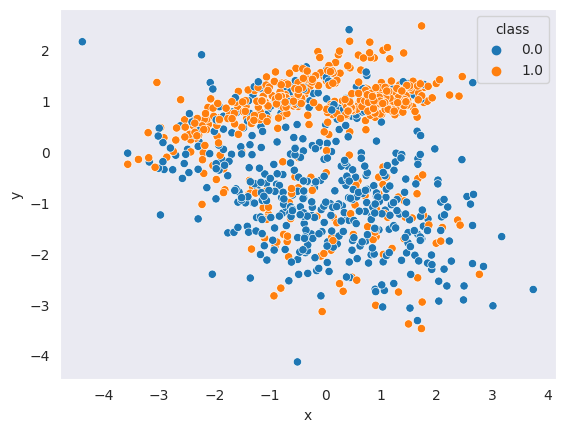

In [11]:
data, classes = make_classification(1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

np.random.shuffle(classes[:500])

data_full = np.hstack([data, classes.reshape((-1,1))])
df = pd.DataFrame(data_full, columns=["x", "y", "class"])
sns.scatterplot(df, x="x", y="y", hue="class")

In [12]:
e = np.exp(1)
pi = np.pi
expr = "p_0 + p_1*x_0 + p_2*x_1 + p_3*x_0**2 + p_4*x_0*x_1 + p_5*x_1**2 + p_6*x_0**3 + p_7*x_0**2*x_1 + p_8*x_0*x_1**2 + p_9*x_1**3"
# expr = "p_0*(x_0 - p_1)**2 + p_2*(x_1 - p_3)**2 - 1"

# n_gs = 2
# x_vars = sympy.symbols([f"x_{i}" for i in range(2)])
# p_vars = sympy.symbols([f"p_{i}" for i in range(6*n_gs + n_gs + 1)])

# x = sympy.Matrix([x_vars[0:1], x_vars[1:2]])

# mu = sympy.Matrix([p_vars[0:1], p_vars[1:2]])
# sigma = sympy.Matrix([p_vars[2:4], p_vars[4:6]])
# sigma_det = sigma.det()
# a = ((x-mu).T*sigma*(x-mu)).det()
# g1 = sympy.exp(-0.5 * a)/sympy.sqrt(4*pi*sympy.Abs(sigma_det))

# mu = sympy.Matrix([p_vars[6:7], p_vars[7:8]])
# sigma = sympy.Matrix([p_vars[8:10], p_vars[10:12]])
# sigma_det = sigma.det()
# a = ((x-mu).T*sigma*(x-mu)).det()
# g2 = sympy.exp(-0.5 * a)/sympy.sqrt(4*pi*sympy.Abs(sigma_det)) 


# expr = -p_vars[-1] + p_vars[-2] * g1 +  p_vars[-3] * g2 
# expr = str(expr)

objfunc = SymbolicRegression(expr, data, classes)
display(objfunc.equation)

params = {
    # "stop_cond": "time_limit or convergence",
    "stop_cond": "time_limit",
    "time_limit": 60.0,
    "cpu_time_limit": 10.0,
    "ngen": 100,
    "neval": 6e5,
    "fit_target": 1e-10,
    "patience": 15,

    "verbose": True,
    "v_timer": 0.5,

    "encoding": "real",
    "DE_type": "de/current-to-best/1",
    "alpha": 0.5,
    "mut_str": 1
}

# alg = differential_evolution(objfunc, params)
alg = particle_swarm(objfunc, params)
# alg = hill_climb(objfunc, params)
# alg = simulated_annealing(objfunc, params)
# alg = genetic_algorithm(objfunc, params)
# alg = evolution_strategy(objfunc, params)
# alg = random_search(objfunc, params)
alg.optimize()

p_0 + p_1*x_0 + p_2*x_1 + p_3*x_0**2 + p_4*x_0*x_1 + p_5*x_1**2 + p_6*x_0**3 + p_7*x_0**2*x_1 + p_8*x_0*x_1**2 + p_9*x_1**3

Initializing optimization of some function using PSO
----------------------------------------------------

Optimizing some function using PSO:
	Real time Spent: 0.86 s
	CPU time Spent:  0.86 s
	Generation: 0
	Best fitness: 0.6792527170108681
	Evaluations of fitness: 100
	diversity: 5.34
	mean speed: 0.486

Optimizing some function using PSO:
	Real time Spent: 1.75 s
	CPU time Spent:  1.75 s
	Generation: 1
	Best fitness: 0.7061628246512988
	Evaluations of fitness: 200
	diversity: 4.2
	mean speed: 2.6

Optimizing some function using PSO:
	Real time Spent: 2.53 s
	CPU time Spent:  2.53 s
	Generation: 2
	Best fitness: 0.7071248284993139
	Evaluations of fitness: 300
	diversity: 5.04
	mean speed: 0.781

Optimizing some function using PSO:
	Real time Spent: 3.36 s
	CPU time Spent:  3.36 s
	Generation: 3
	Best fitness: 0.7181228724914901
	Evaluations of fitness: 400
	diversity: 5.92
	mean speed: 0.375

Optimizing some function using PSO:
	Real time Spent: 4.13 s
	CPU time Spent:  4.13 s
	Gener

(array([-2.87883145, -0.12872371,  8.44668386, -5.5420043 ,  6.78762587,
        -0.77241919, -2.53721133, 10.        ,  2.29388551,  0.02471336]),
 0.7260749042996172)

In [13]:
vector = alg.best_solution()[0]

eq = objfunc.decision_boundary().subs(zip(objfunc.curve_params, vector))
objfunc.decision_boundary().subs(zip(objfunc.curve_params, np.round(vector, 2)))

Eq(-2.54*x_0**3 + 10.0*x_0**2*x_1 - 5.54*x_0**2 + 2.29*x_0*x_1**2 + 6.79*x_0*x_1 - 0.13*x_0 + 0.02*x_1**3 - 0.77*x_1**2 + 8.45*x_1 - 2.88, 0)

x_0 x_1


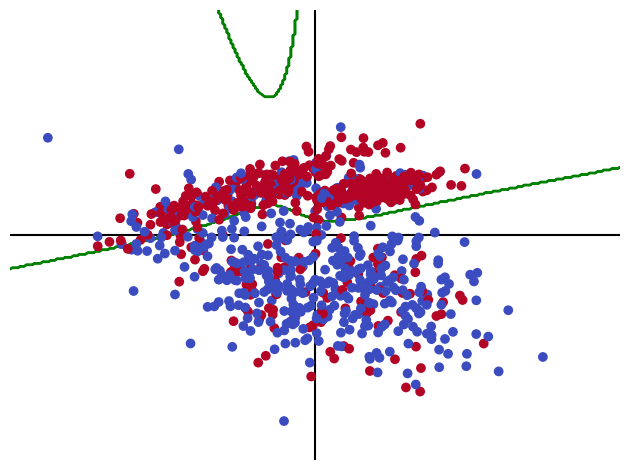

In [14]:
x, y = sympy.symbols("x_0 x_1")
print(x, y)

p = sympy.plot_implicit(eq, x, y, show=False, line_color="green", adaptive=False, axis=False)
backend = MatplotlibBackend(p)
backend.process_series()
backend.fig.tight_layout()
plt_ax = backend.plt
plt_ax.scatter(data[:,0], data[:,1], c=classes, cmap="coolwarm", zorder=2)
plt_ax.axvline(0, color="black", zorder=-1)
plt_ax.axhline(0, color="black", zorder=-1)
plt.show()